In [2]:
import warnings, pickle, os, itertools
from dataclasses import dataclass
from joblib import Parallel, delayed, parallel_backend

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ImportError:
    pass

import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 300)

from IPython.display import display
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)})

import shap
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

%load_ext autoreload
%autoreload 1

In [25]:
from utils.evaluation import plot_roc_curves, plot_pr_curves, plot_alert_rate, get_metrics
from models import Estimator_LightGBM, Resampler_RandomUnderSampler, Resampler_SMOTE
%aimport utils.evaluation, models

In [15]:
class Notebook:
    RESULTS_DIR = 'results/systematic_ccu'
    STORAGE = 'sqlite:///results/systematic_ccu/studies.db'

In [21]:
from sklearn.model_selection import train_test_split
from dataset import SCIData, SCICols
%aimport dataset

sci = SCIData.load('data/sci.h5')

scii = (
    SCIData(SCIData.quickload("data/sci_processed.h5").sort_values("AdmissionDateTime"))
    .mandate(SCICols.news_data_raw)
    .derive_critical_event(within=1, return_subcols=True)
    .augment_shmi(onehot=True)
   # .omit_redundant()
    .derive_ae_diagnosis_stems(onehot=False)
    .categorize()
   # .onehot_encode_categories()
)

sci_train, sci_test, _, y_test_mortality, _, y_test_criticalcare = train_test_split(
    scii,
    scii.DiedWithinThreshold,
    scii.CriticalCare,
    test_size=0.33,
    random_state=42,
    shuffle=False,
)
sci_train, sci_test = SCIData(sci_train), SCIData(sci_test)
# (X_train, y_train), (X_test, y_test) = (
#     sci_train.xy(outcome="CriticalEvent", dropna=False, fillna=False),
#     sci_test.xy(outcome="CriticalEvent", dropna=False, fillna=False),
# )
_, y_test = sci_test.xy()

In [6]:
from systematic_comparison import construct_study, get_studies
from models import Estimator_LogisticRegression, Estimator_IsolationForest, Estimator_RandomForest
%aimport systematic_comparison
optuna.logging.set_verbosity(optuna.logging.INFO)
study_grid = dict(
    # estimator=[Estimator_LightGBM, Estimator_IsolationForest, Estimator_LogisticRegression, Estimator_RandomForest, Estimator_TabNet, Estimator_XGBoost],
    estimator=[Estimator_IsolationForest],
    resampler=[None, Resampler_RandomUnderSampler, Resampler_SMOTE],
    features=sci_train.feature_group_combinations,
)
#studies = [construct_study(**_, n_trials=2, sci_train=SCIData(sci_train.head(1000)), sci_test=SCIData(sci_test.head(1000))) for _ in get_studies(sci_train, study_grid)]


In [5]:
feature_groups = sci_train.feature_groups

In [33]:
news_performance = dict(
    name = 'Baseline (NEWS)',
    estimator = 'NEWS Score',
    resampler = None,
    features = 'Baseline (NEWS)'
) | get_metrics(y_test, sci_test.NEWS_score >= 7, sci_test.NEWS_score)

In [36]:
result_files = [f'{Notebook.RESULTS_DIR}/{_}' for _ in os.listdir(Notebook.RESULTS_DIR) if _.endswith('.h5')]
y_preds = pd.concat([pd.read_hdf(_, 'y_preds') for _ in result_files], axis=1).reset_index(drop=True)
metrics = pd.concat([pd.read_hdf(_, 'metrics') for _ in result_files], axis=0).reset_index(drop=True)
#hyperparameters = {name: optuna.load_study(study_name = name, storage=Notebook.STORAGE).best_params for name in metrics.name.values}

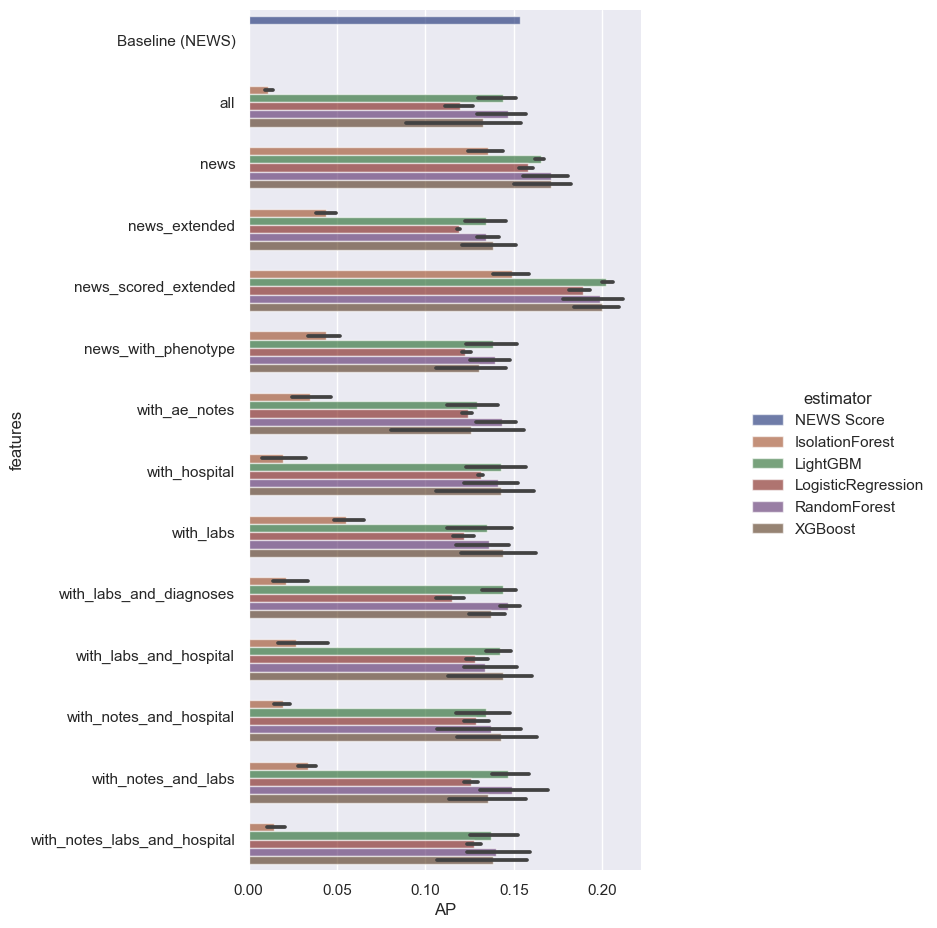

In [38]:
def feature_ablation_barplot(metrics, baseline=True):
    sns.set_style('darkgrid')
    df = metrics.copy()
    if baseline:
        df.loc[-1] = news_performance
    g = sns.catplot(
        data=df.groupby(['name', 'estimator']).max().reset_index(), kind="bar",
        x="AP", y="features", hue="estimator",
        palette="dark", alpha=.6, height=6, orient='h',
    )
    g.despine(bottom=True)
    g.fig.set_size_inches(12,10)
    #g.ax.set_xlim(0.6, 1.0)

feature_ablation_barplot(metrics)

,name,estimator,resampler,features,AUC,AUC_Upper,AUC_Lower,AP,AP_Upper,AP_Lower,Accuracy,Precision,Recall,F2
2,IsolationForest_No_Resampling_news_scored_exte...,IsolationForest,No_Resampling,news_scored_extended,0.910458,0.932305,0.886085,0.158534,0.215746,0.117687,0.948521,0.065728,0.663507,0.235373
52,LightGBM_RandomUnderSampler_news,LightGBM,RandomUnderSampler,news,0.914732,0.936970,0.890399,0.166384,0.222898,0.124973,0.948746,0.068043,0.687204,0.243697
93,LogisticRegression_RandomUnderSampler_news_sco...,LogisticRegression,RandomUnderSampler,news_scored_extended,0.914702,0.938771,0.889061,0.192467,0.251184,0.145808,0.949196,0.074264,0.753555,0.266332
145,RandomForest_SMOTE_news_scored_extended,RandomForest,SMOTE,news_scored_extended,0.916625,0.939865,0.891026,0.177986,0.229928,0.137805,0.948971,0.073557,0.748815,0.264037
156,XGBoost_No_Resampling_news,XGBoost,No_Resampling,news,0.915797,0.938057,0.892130,0.182495,0.238716,0.136915,0.949021,0.070826,0.715640,0.253696


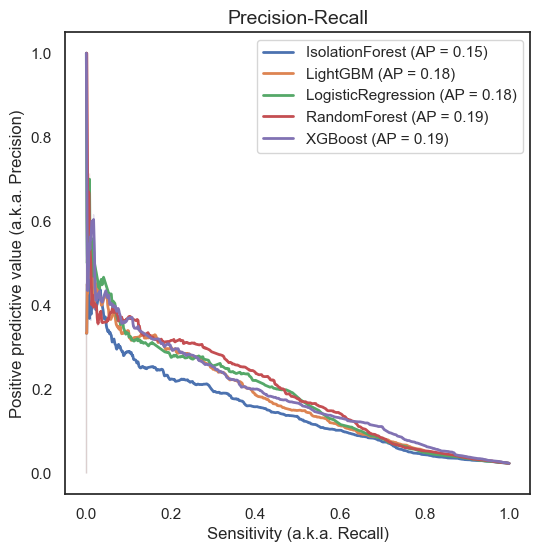

In [19]:
def best_performers(metrics):
    df = metrics.iloc[metrics.groupby('estimator').AUC.idxmax()]
    preds = dict(zip(df.estimator.values, [y_preds[_] for _ in df.name.values]))
    plot_pr_curves(y_test, preds)
    return df

best_performers(metrics)